# Analysis of PN emission lines of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS France
- date   : January 19th 2017
- update : January 25 2017

The goal is to calibrate in wavelength the X axis.
For this the raw spectra in the dat are read as well as the spectra simulated.
The simulated may have been checked by View_SimSpectrum_XX.ipynb

In [46]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [47]:
print theNotebook

AnalysisEmissionLines_HEN2_5


In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [49]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [50]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [51]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [52]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [53]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [54]:
from IPython.display import Image, display

In [55]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [56]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [57]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [ ]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

## Choose the Fit order

In [58]:
FIT_ORDER=2

## Output directory for images generated in the notebook view (not true fits images)

In [59]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [60]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

- Left and Right spectra in the data

In [61]:
inputdir="./spectrum_fitsspec"
object_name='HEN_2_5'

## Location of corrected images
----------------------------------

In [62]:
input_filelist=os.listdir(inputdir) 

In [63]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [64]:
print input_filelist[0:5]

['finalSpectra_HEN2_5_20170119_507.fits'
 'finalSpectra_HEN2_5_20170119_508.fits'
 'finalSpectra_HEN2_5_20170119_509.fits'
 'finalSpectra_HEN2_5_20170119_510.fits'
 'finalSpectra_HEN2_5_20170119_511.fits']


In [65]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [66]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0


    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^finalSpectra_HEN2_5_20170119_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages    
    

In [67]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [68]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [69]:
print indexes_files

[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523]


In [70]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [71]:
sorted_numbers=indexes_files[sorted_indexes]

In [72]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [73]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [74]:
#sorted_files

## Build full filename
----------------------------

In [75]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [76]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [77]:
print sorted_filenames.shape

(17,)


## Acces to spectrum data
----------------------------------

In [78]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [79]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_spectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        the_spectrum=table_data.field('Spectrum')
 
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_spectra.append(the_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_spectra

In [80]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_spectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [81]:
len(all_spectra)

17

In [82]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: 
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0,20000.)
        axarr[iy,ix].set_xlim(0,1500.)
    
    title='spectra in the band'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

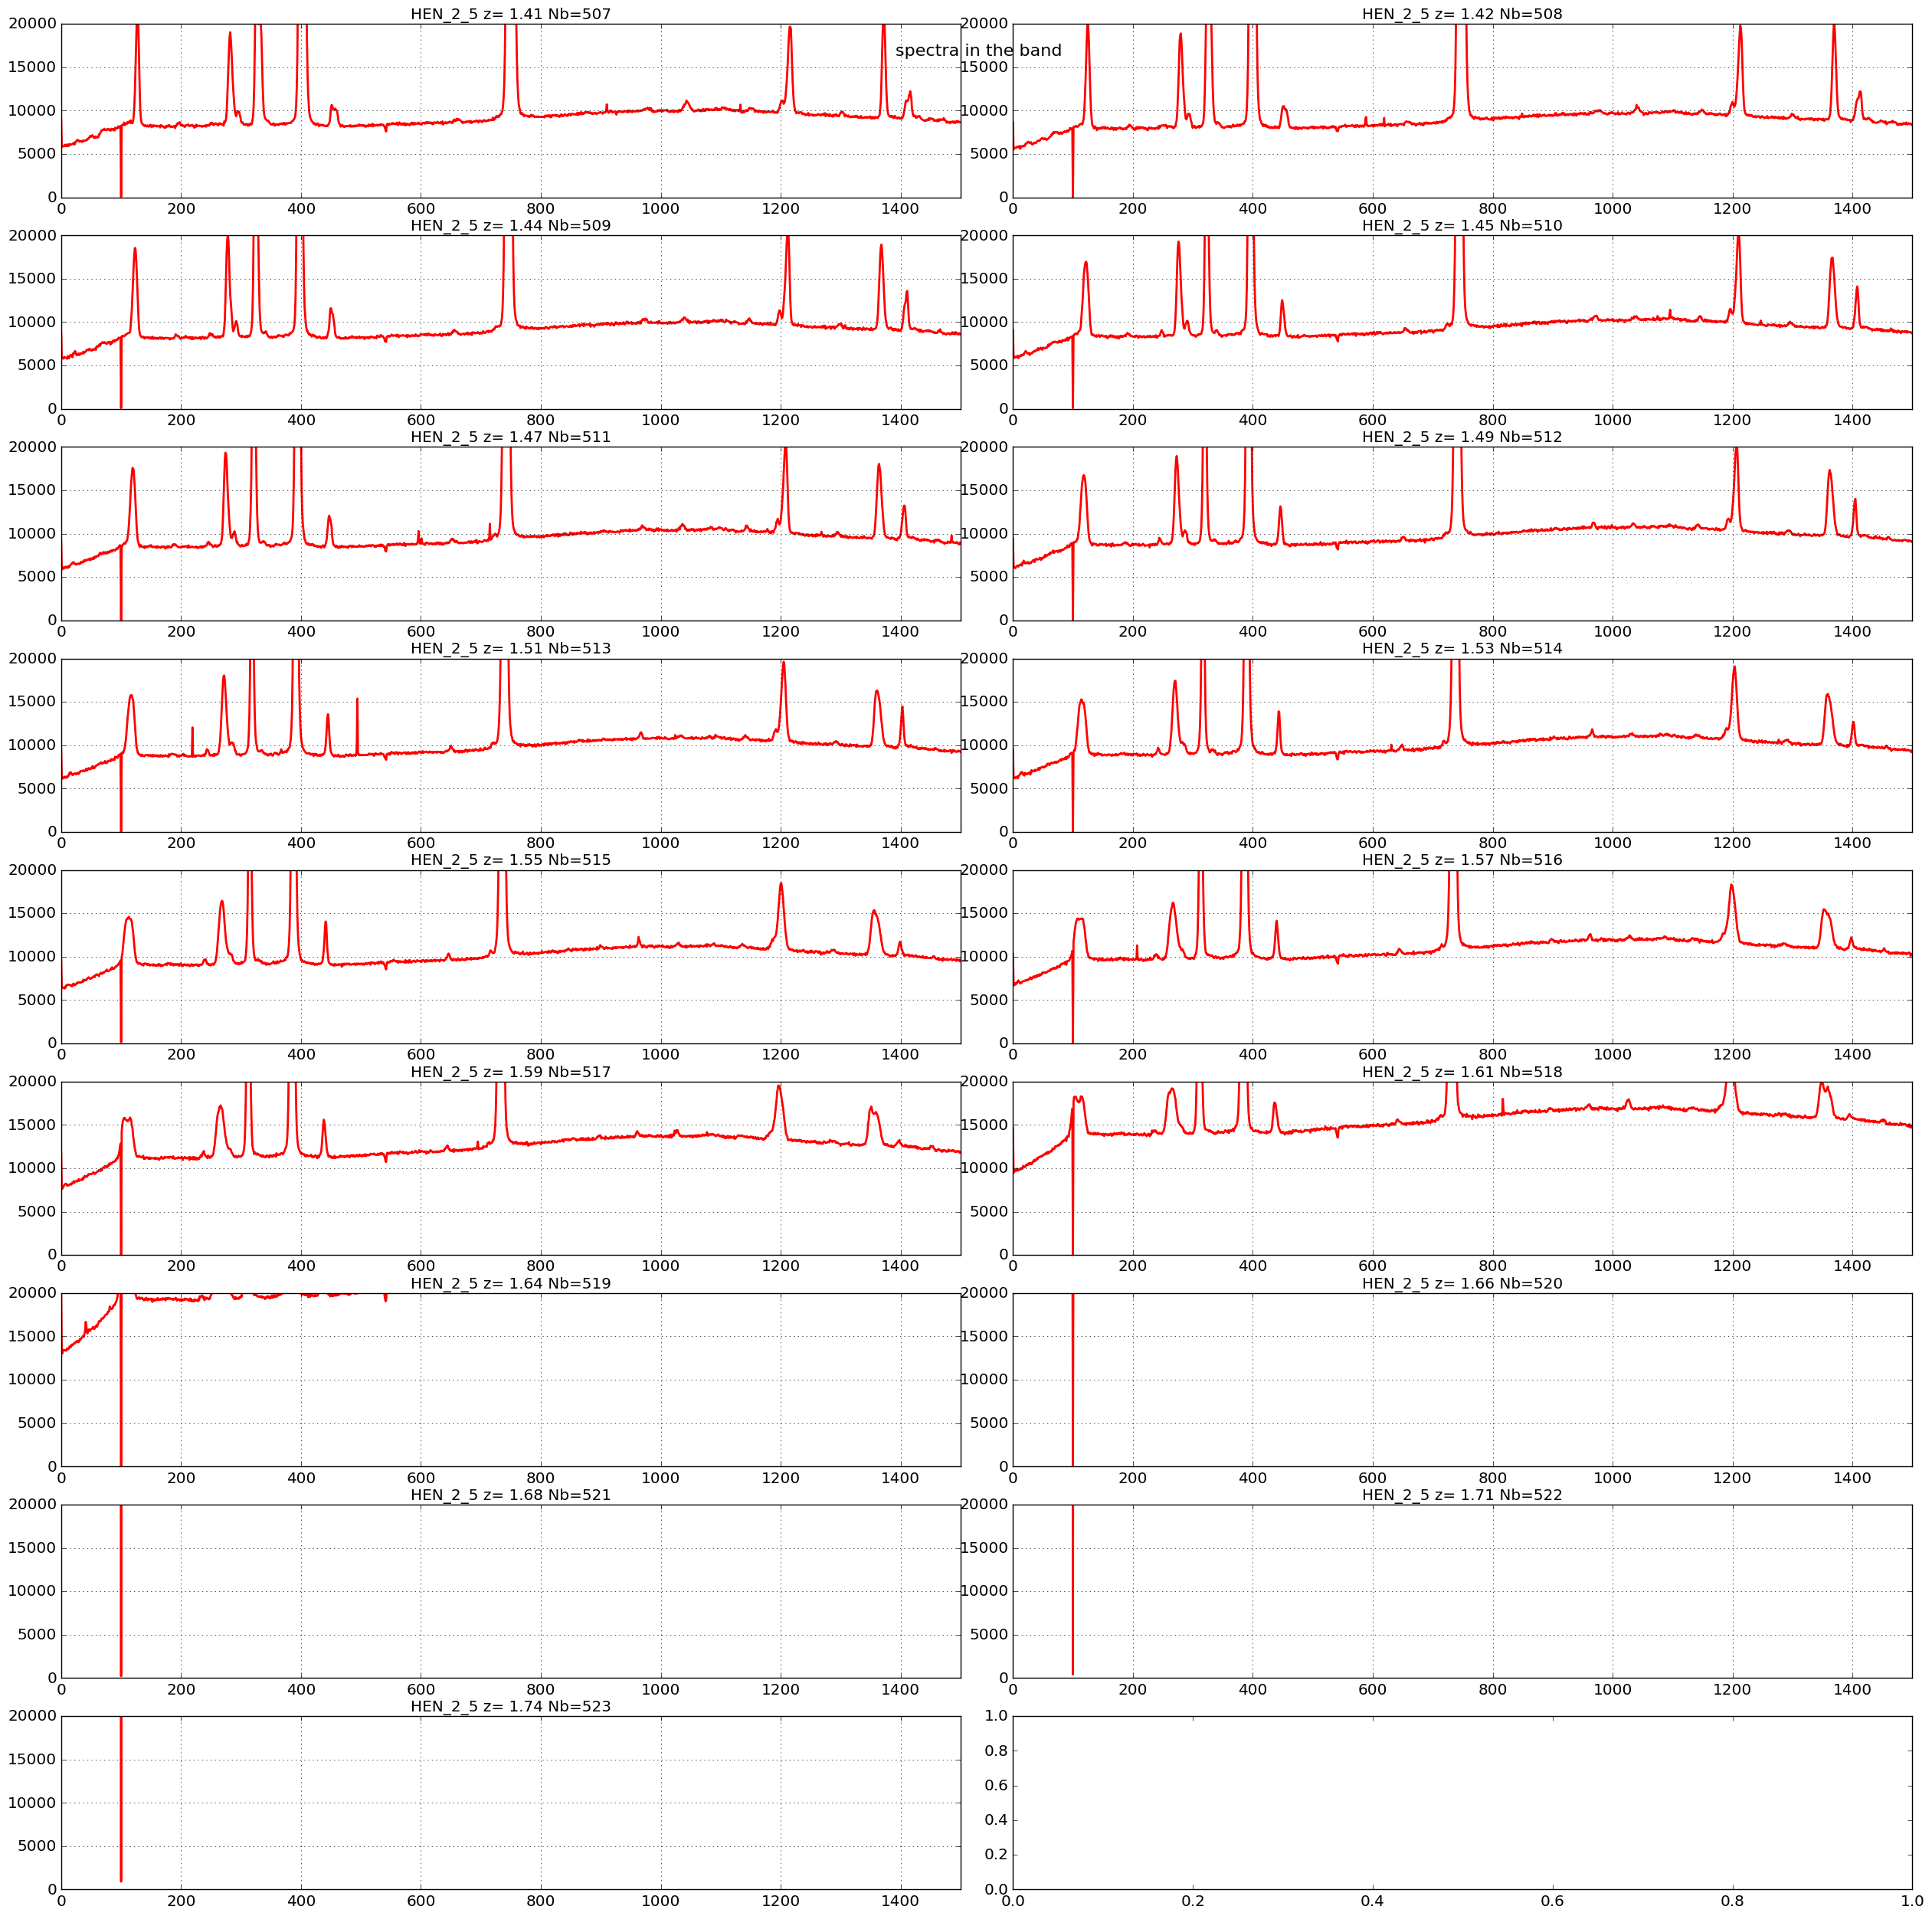

In [83]:
ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,'allspectra.pdf')

In [95]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def FitBackground(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: 
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        spectrum=all_spectra[index]
        
        x=np.arange(spectrum.shape[0])
        y=spectrum
        
        z = np.polyfit(x, y, 15)
        p = np.poly1d(z)
        
        fity=p(x)
        
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].plot(fity,'b-',lw=2)
        
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0,30000.)
        axarr[iy,ix].set_xlim(0,1500.)
    
    title='fit spectra'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

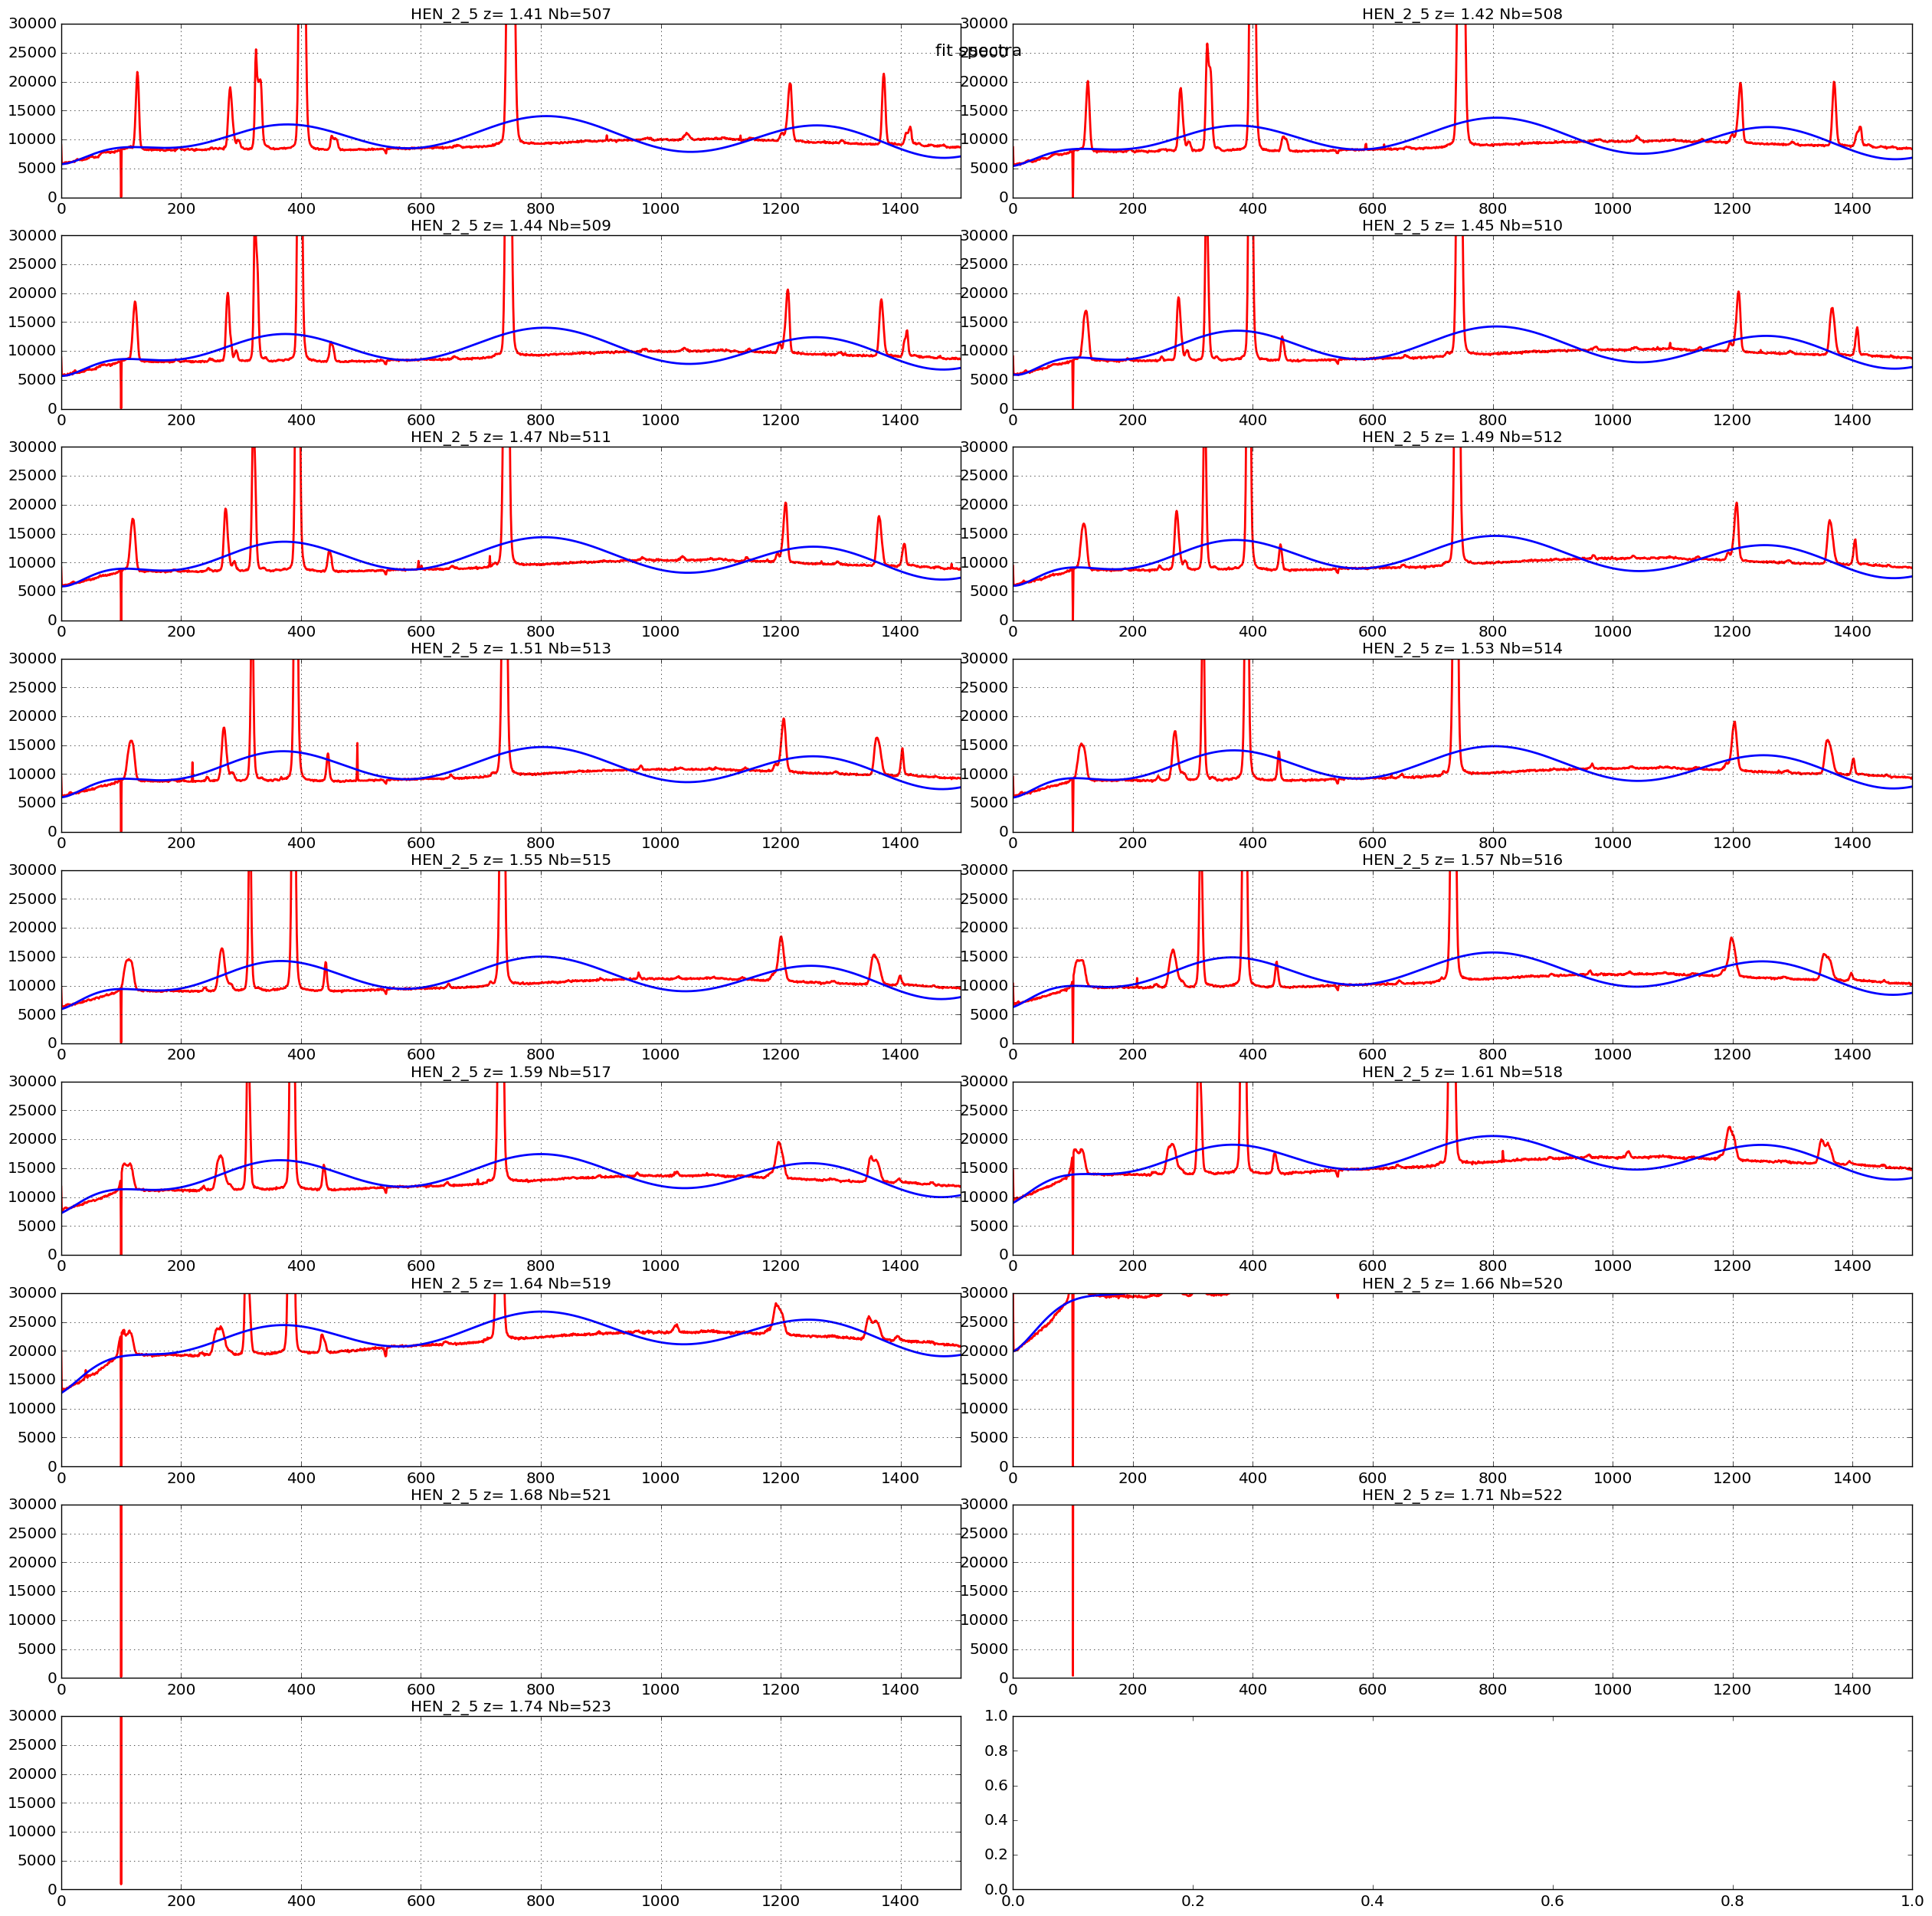

In [99]:
FitBackground(all_spectra,all_titles,object_name,dir_top_images,'allfitspectra.pdf')

In [169]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def SelectLines(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    CutLines: 
    ==============
    """
    YMAX=40000.
    YMIN=0
    
    X1=100
    X2=150
    X3=250
    X4=295
    

    X5=710
    X6=780
    
    X7=1180
    X8=1240
    
    X9=1340
    X10=1390
    
  
    X11=425
    X12=470

    eline1 = []
    eline2 = []
    eline3 = []
    eline4 = []
    eline5 = []
    
    
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/2)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,2,figsize=(25,25))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%2
        iy=index/2
        spectrum=all_spectra[index]
        
        x=np.arange(spectrum.shape[0])
        y=spectrum
        
        
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        
        axarr[iy,ix].plot([X1,X1],[YMIN,YMAX],'b-',lw=1)
        axarr[iy,ix].plot([X2,X2],[YMIN,YMAX],'b-',lw=1)
        
        axarr[iy,ix].plot([X3,X3],[YMIN,YMAX],'g-',lw=1)
        axarr[iy,ix].plot([X4,X4],[YMIN,YMAX],'g-',lw=1)
        
        axarr[iy,ix].plot([X5,X5],[YMIN,YMAX],'r-',lw=1)
        axarr[iy,ix].plot([X6,X6],[YMIN,YMAX],'r-',lw=1)
        
        axarr[iy,ix].plot([X7,X7],[YMIN,YMAX],'g-',lw=1)
        axarr[iy,ix].plot([X8,X8],[YMIN,YMAX],'g-',lw=1)
        
        axarr[iy,ix].plot([X9,X9],[YMIN,YMAX],'b-',lw=1)
        axarr[iy,ix].plot([X10,X10],[YMIN,YMAX],'b-',lw=1)
        
        
        axarr[iy,ix].plot([X11,X11],[YMIN,YMAX],'k-',lw=1)
        axarr[iy,ix].plot([X12,X12],[YMIN,YMAX],'k-',lw=1)
        
        line1=spectrum[X1:X2]
        line2=spectrum[X3:X4]
        
        line3=spectrum[X7:X8]
        line4=spectrum[X9:X10]
        
        line5=spectrum[X11:X12]
        
        eline1.append(line1)
        eline2.append(line2)
        eline3.append(line3)
        eline4.append(line4)
        eline5.append(line5)
        
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(YMIN,YMAX)
        axarr[iy,ix].set_xlim(0,1500)
    
    title='Line selection'
    
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    return eline1, eline2,eline3,eline4,eline5

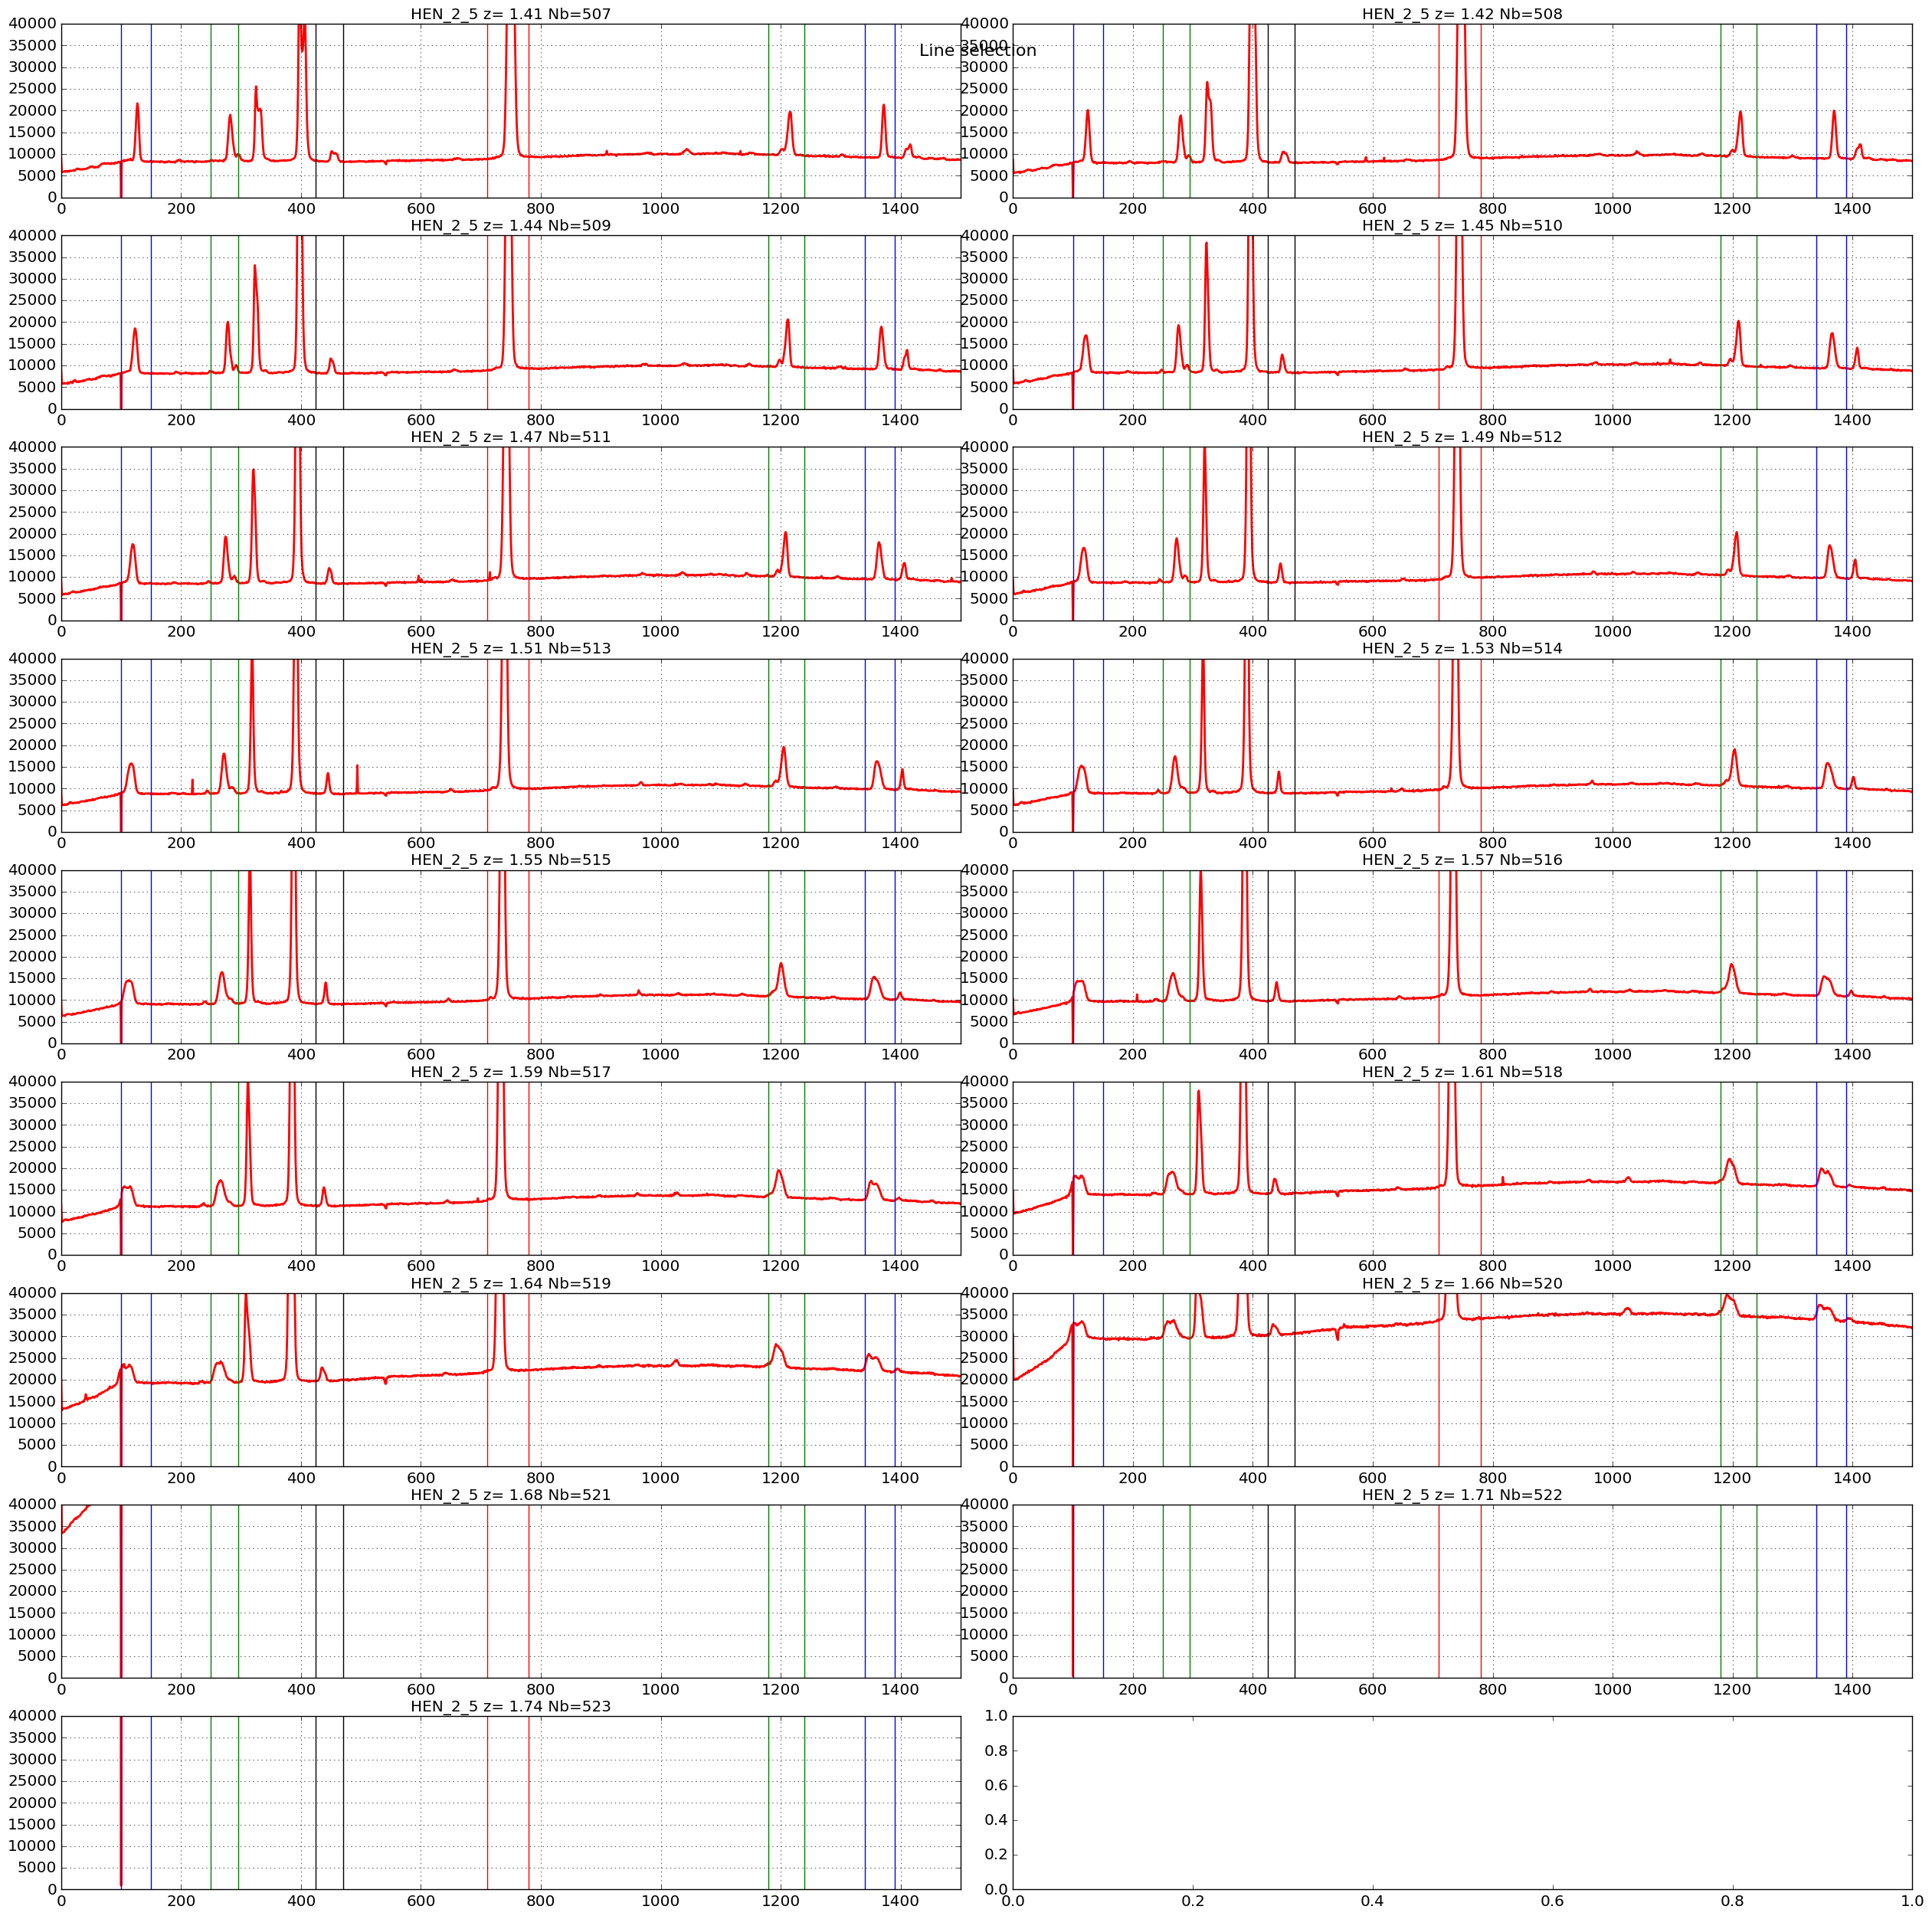

In [170]:
eline1,eline2,eline3,eline4,eline5=SelectLines(all_spectra,all_titles,object_name,dir_top_images,'selectlines.pdf')

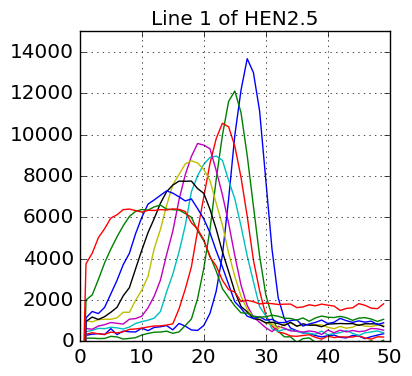

In [158]:
index=0
indexmax=11
BG1=8000
for line in eline1:
    index+=1
    if(index<indexmax):
        plt.plot(line-BG1)
plt.ylim(0,15000)
plt.grid(True)
plt.title('Line 1 of HEN2.5')

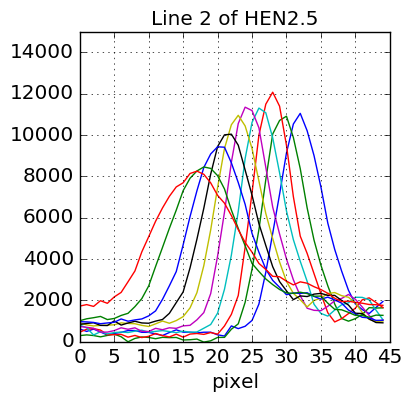

In [152]:
index=0
indexmax=11
BG2=8000
for line in eline2:
    index+=1
    if(index<indexmax):
        plt.plot(line-8000)
plt.ylim(0,15000)
plt.grid(True)
plt.xlabel('pixel')
plt.title('Line 2 of HEN2.5')

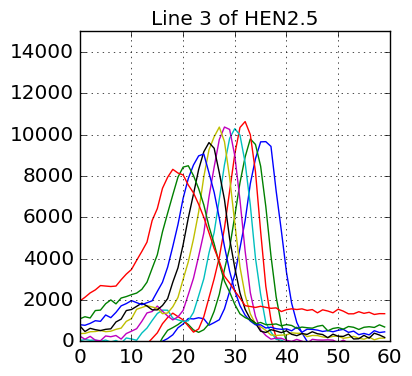

In [154]:
index=0
indexmax=11
for line in eline3:
    index+=1
    if(index<indexmax):
        plt.plot(line-10000)
plt.ylim(0,15000)
plt.grid(True)
plt.title('Line 3 of HEN2.5')

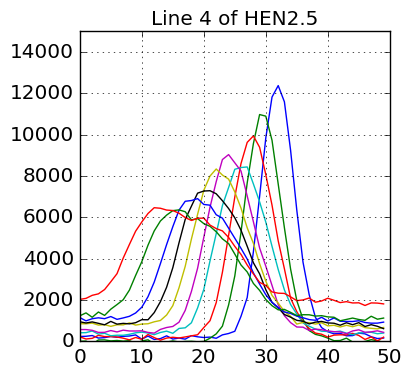

In [157]:
index=0
indexmax=11
for line in eline4:
    index+=1
    if(index<indexmax):
        plt.plot(line-9000)
plt.ylim(0,15000)
plt.grid(True)
plt.title('Line 4 of HEN2.5')

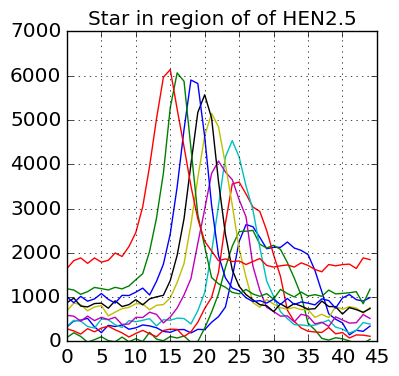

In [177]:
index=0
BG5=8000
indexmax=11
for line in eline5:
    index+=1
    if(index<indexmax):
        plt.plot(line-BG5)
plt.ylim(0,7000)
plt.grid(True)
plt.title('Star in region of of HEN2.5')